<a href="https://colab.research.google.com/github/pintophilip/GPTs/blob/main/HelpMate_AI_Live_Session_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agenda for the live session

- Quick Introduction (~5 minutes)
- Recap of RAG (~10 minutes)
- Problem Statement Discussion (~10 minutes)
- System Design Discussion (~30 minutes)
- Code Explanation (~20 minutes)
- Doubt Resolution (~20 minutes)

In [ ]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... do

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 7.2 MB/s eta 0:00:00


In [ ]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/HelpMate_AI_Support_Session/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

## Quick Recap of RAG

Quick Recap of a RAG system

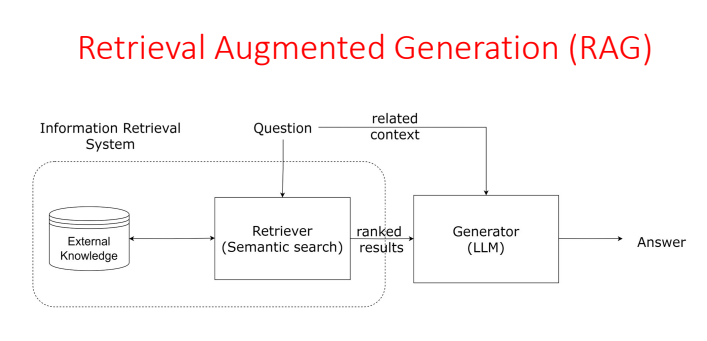

In [ ]:
## Issues with normal LLMs
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"What is the revenue of uber in 2022?"},
          ]

In [ ]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"I do not have real-time information on specific financial data for companies. I recommend checking the latest updates on Uber's revenue from official sources such as their investor relations website or financial news outlets."

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

However there's a trick you can use!!

Here's the relevant snippet from uber's annual filings report uber_2022. pdf page 51

*Revenue was `$31.9 billion`, or up 83% year-over-year. Revenue growth outpaced Gross Bookings growth primarily due to a
`$4.8 billion` increase in our Freight business primarily due to the acquisition of Transplace during the fourth quarter of 2021, the net
favorable impact to Mobility revenue of `$3.9 billion` as a result of business model changes in the UK and accruals made for the
resolution of historical claims in the UK relating to the classification of drivers, and an `$892 million` increase in Delivery revenue
resulting from an increase in certain Courier payments and incentives that are recorded in cost of revenue, exclusive of depreciation
and amortization, for certain markets where we are primarily responsible for Delivery services and pay Couriers for services provided.*

In [ ]:
retrieved = """Revenue was $31.9 billion, or up 83% year-over-year.
Revenue growth outpaced Gross Bookings growth primarily due to a  $4.8 billion increase in our Freight business
"""

In [ ]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2022?. Use the information presented in '{retrieved}' """},
          ]

In [ ]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"Based on the information provided, Uber's revenue in 2022 was $31.9 billion."

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

## Starter Code explanation

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [ ]:
pdf_path = "/content/drive/MyDrive/HelpMate_AI_Support_Session/data_C6/data"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing uber_2022.pdf
Finished processing uber_2022.pdf
All PDFs have been processed.


In [ ]:
finance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
finance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,uber_2022.pdf
1,Page 2,Large accelerated filer ☒ Accelerated filer ☐ ...,uber_2022.pdf
2,Page 3,"UBER TECHNOLOGIES, INC. TABLE OF CONTENTS Page...",uber_2022.pdf
3,Page 4,SPECIAL NOTE REGARDING FORWARD-LOOKING STATEME...,uber_2022.pdf
4,Page 5,looking statements as predictions of future ev...,uber_2022.pdf


In [ ]:
len(finance_pdfs_data)

149

In [ ]:
finance_pdfs_data['Metadata'] = finance_pdfs_data.apply(lambda x: {'filing_name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [ ]:
finance_pdfs_data.head(5)

,Page No.,Page_Text,Document Name,Metadata
0,Page 1,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,uber_2022.pdf,"{'filing_name': 'uber_2022', 'Page_No.': 'Page..."
1,Page 2,Large accelerated filer ☒ Accelerated filer ☐ ...,uber_2022.pdf,"{'filing_name': 'uber_2022', 'Page_No.': 'Page..."
2,Page 3,"UBER TECHNOLOGIES, INC. TABLE OF CONTENTS Page...",uber_2022.pdf,"{'filing_name': 'uber_2022', 'Page_No.': 'Page..."
3,Page 4,SPECIAL NOTE REGARDING FORWARD-LOOKING STATEME...,uber_2022.pdf,"{'filing_name': 'uber_2022', 'Page_No.': 'Page..."
4,Page 5,looking statements as predictions of future ev...,uber_2022.pdf,"{'filing_name': 'uber_2022', 'Page_No.': 'Page..."


## Generate and Store Embeddings using OpenAI and ChromaDB
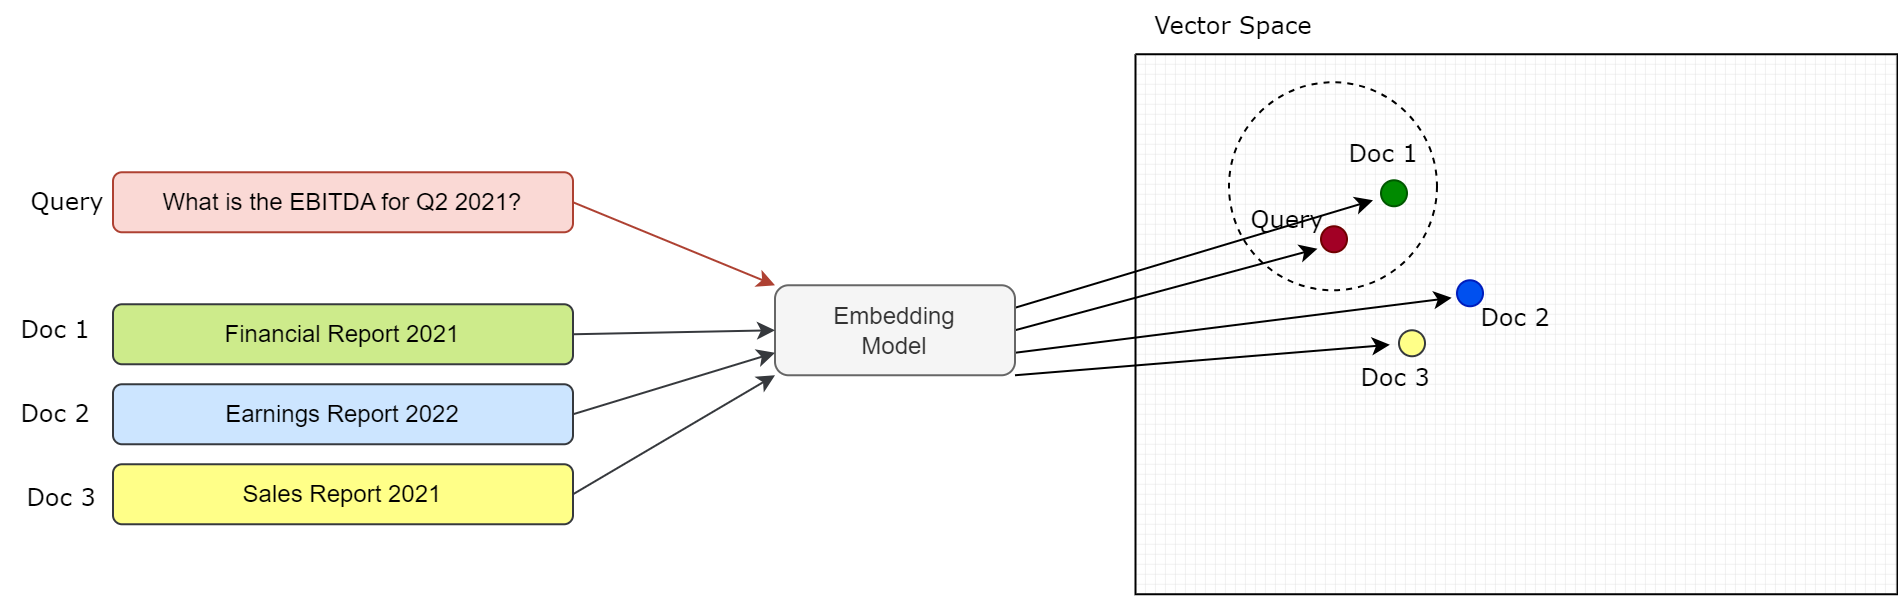

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = "/content/drive/MyDrive/HelpMate_AI_Support_Session/data_C6/ChromaDB_Data"

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
## Create an empty collection
financedata_collection = client.get_or_create_collection(name='RAG_on_Uber', embedding_function=embedding_function)

In [ ]:
documents_list = finance_pdfs_data["Page_Text"].tolist()
metadata_list = finance_pdfs_data['Metadata'].tolist()

In [ ]:
#metadata_list

In [ ]:
?financedata_collection.add

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

financedata_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
financedata_collection.peek(1)

{'ids': ['0'],
 'embeddings': [[0.00550387566909194,
   -0.03536223620176315,
   0.010723638348281384,
   -0.03874517232179642,
   -0.00021907308837398887,
   -0.007142484653741121,
   -0.028173500671982765,
   -0.015394994989037514,
   0.008397870697081089,
   -0.01930651254951954,
   0.009778794832527637,
   0.009891118854284286,
   -0.0035943679977208376,
   0.01090864185243845,
   0.006498273462057114,
   -0.012071525678038597,
   0.005804507527500391,
   -0.004228668287396431,
   0.02327089011669159,
   0.005328782368451357,
   0.00014463780098594725,
   0.013611025176942348,
   -0.032296452671289444,
   0.0027469824999570847,
   -0.01643894799053669,
   0.008919847197830677,
   0.0147078363224864,
   -0.01657109335064888,
   0.01419246755540371,
   -0.01076328195631504,
   -0.01822291687130928,
   0.0023109009489417076,
   -0.027380626648664474,
   0.009785402566194534,
   -0.020905477926135063,
   0.003452311037108302,
   0.014945698902010918,
   -0.021896572783589363,
   0.0428

In [ ]:
cache_collection = client.get_or_create_collection(name='Finance2_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': ['What is the revenue of uber in 2022?'],
 'embeddings': [[0.024335524067282677,
   -0.04992775246500969,
   -0.0031401203013956547,
   -0.00044467311818152666,
   0.00702313520014286,
   -0.021115222945809364,
   -0.026272941380739212,
   -0.013902273960411549,
   -0.022659920156002045,
   -0.012953201308846474,
   0.026652568951249123,
   0.013561916537582874,
   -0.013201924040913582,
   -0.02940160594880581,
   0.018340004608035088,
   -0.02310500293970108,
   0.0180389191955328,
   -0.006918410304933786,
   0.024152254685759544,
   0.007756211794912815,
   0.0014898799126967788,
   -0.004107192624360323,
   -0.022358834743499756,
   -0.007271857932209969,
   0.0029683054890483618,
   0.028563804924488068,
   0.027438009157776833,
   0.006234423723071814,
   0.026076581329107285,
   -0.014137905091047287,
   0.01751529425382614,
   0.004195554181933403,
   -0.01476625632494688,
   0.004814087878912687,
   -0.029794326052069664,
   -0.010911059565842152,
   0.011663772165775

## Semantic Search with Cache

We have created 2 collections
- financedata_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the financedata_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

In [ ]:
# Read the user query
query = input()

What is the revenue of uber in 2022?


In [ ]:
query

'What is the revenue of uber in 2022?'

In [ ]:
## Let's query the above result
?financedata_collection.query

In [ ]:
## Quickly checking the results of the query
results = financedata_collection.query(
      query_texts=query,
      n_results=10
      )

In [ ]:
results

{'ids': [['51', '54', '75', '50', '122', '57', '55', '64', '48', '82']],
 'distances': [[0.2703339457511902,
   0.28533297777175903,
   0.29410797357559204,
   0.3078728914260864,
   0.3161159058058129,
   0.3372538983821869,
   0.3407256305217743,
   0.3413376808166504,
   0.34435537457466125,
   0.346622109413147]],
 'metadatas': [[{'Page_No.': 'Page 52', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 55', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 76', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 51', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 123', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 58', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 56', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 65', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 49', 'filing_name': 'uber_2022'},
   {'Page_No.': 'Page 83', 'filing_name': 'uber_2022'}]],
 'embeddings': None,
 'documents': [['$142 million net unrealized loss on other investments. Net loss at

In [ ]:
for key, val in results.items():
  print(key)

ids
distances
metadatas
embeddings
documents
uris
data


In [ ]:
for key, val in results.items():
  print(val)

[['51', '54', '75', '50', '122', '57', '55', '64', '48', '82']]
[[0.2703339457511902, 0.28533297777175903, 0.29410797357559204, 0.3078728914260864, 0.3161159058058129, 0.3372538983821869, 0.3407256305217743, 0.3413376808166504, 0.34435537457466125, 0.346622109413147]]
[[{'Page_No.': 'Page 52', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 55', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 76', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 51', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 123', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 58', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 56', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 65', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 49', 'filing_name': 'uber_2022'}, {'Page_No.': 'Page 83', 'filing_name': 'uber_2022'}]]
None
[['$142 million net unrealized loss on other investments. Net loss attributable to Uber Technologies, Inc. also included $1.8 billion of stock-based compensation expense. Adjusted EBITDA was $

Building the cache

In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = financedata_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if key not in ['embeddings', 'uris','data']:
          for i in range(10):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Found in cache!


In [ ]:
results_df

,IDs,Documents,Distances,Metadatas
0,51,$142 million net unrealized loss on other inve...,0.2703339457511902,"{'Page_No.': 'Page 52', 'filing_name': 'uber_2..."
1,54,The following table sets forth the components ...,0.28533297777175903,"{'Page_No.': 'Page 55', 'filing_name': 'uber_2..."
2,75,"UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...",0.29410797357559204,"{'Page_No.': 'Page 76', 'filing_name': 'uber_2..."
3,50,Financial and Operational Highlights Year Ende...,0.3078728914260864,"{'Page_No.': 'Page 51', 'filing_name': 'uber_2..."
4,122,"(1) In 2022, we modified our arrangements in c...",0.3161159058058129,"{'Page_No.': 'Page 123', 'filing_name': 'uber_..."
5,57,Provision for (Benefit from) Income Taxes Year...,0.3372538983821869,"{'Page_No.': 'Page 58', 'filing_name': 'uber_2..."
6,55,"Mobility business, and a $1.4 billion increase...",0.3407256305217743,"{'Page_No.': 'Page 56', 'filing_name': 'uber_2..."
7,64,United States is sufficient to fund our workin...,0.3413376808166504,"{'Page_No.': 'Page 65', 'filing_name': 'uber_2..."
8,48,$200 leveL xednI $100 $0 5/10/19 6/28/19 9/30/...,0.34435537457466125,"{'Page_No.': 'Page 49', 'filing_name': 'uber_2..."
9,82,"UBER TECHNOLOGIES, INC. NOTES TO CONSOLIDATED ...",0.346622109413147,"{'Page_No.': 'Page 83', 'filing_name': 'uber_2..."


In [ ]:
## Checking if the cache also contains the results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

https://www.sbert.net/examples/applications/retrieve_rerank/README.html


<br>

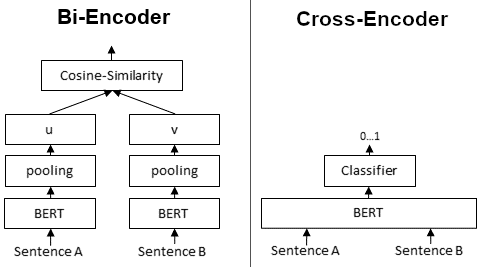

<br>

In [ ]:
!pip install sentence_transformers

In [ ]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['What is the revenue of uber in 2022', 'The revenue of uber in 2022 was $31.9 billion'],
                                ['What is the revenue of uber in 2022', 'The revenue of uber in 2022 is good. The revenue of uber is great. The revenue of uber showed great promise']])

In [ ]:
scores

array([10.765812,  8.798939], dtype=float32)

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,51,$142 million net unrealized loss on other inve...,0.2703339457511902,"{'Page_No.': 'Page 52', 'filing_name': 'uber_2...",3.798014
1,54,The following table sets forth the components ...,0.28533297777175903,"{'Page_No.': 'Page 55', 'filing_name': 'uber_2...",3.887935
2,75,"UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...",0.29410797357559204,"{'Page_No.': 'Page 76', 'filing_name': 'uber_2...",6.083312
3,50,Financial and Operational Highlights Year Ende...,0.3078728914260864,"{'Page_No.': 'Page 51', 'filing_name': 'uber_2...",0.173487
4,122,"(1) In 2022, we modified our arrangements in c...",0.3161159058058129,"{'Page_No.': 'Page 123', 'filing_name': 'uber_...",0.580939
5,57,Provision for (Benefit from) Income Taxes Year...,0.3372538983821869,"{'Page_No.': 'Page 58', 'filing_name': 'uber_2...",-2.183668
6,55,"Mobility business, and a $1.4 billion increase...",0.3407256305217743,"{'Page_No.': 'Page 56', 'filing_name': 'uber_2...",-0.352814
7,64,United States is sufficient to fund our workin...,0.3413376808166504,"{'Page_No.': 'Page 65', 'filing_name': 'uber_2...",-4.433627
8,48,$200 leveL xednI $100 $0 5/10/19 6/28/19 9/30/...,0.34435537457466125,"{'Page_No.': 'Page 49', 'filing_name': 'uber_2...",-3.134728
9,82,"UBER TECHNOLOGIES, INC. NOTES TO CONSOLIDATED ...",0.346622109413147,"{'Page_No.': 'Page 83', 'filing_name': 'uber_2...",-4.135162


In [ ]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,51,$142 million net unrealized loss on other inve...,0.2703339457511902,"{'Page_No.': 'Page 52', 'filing_name': 'uber_2...",3.798014
1,54,The following table sets forth the components ...,0.28533297777175903,"{'Page_No.': 'Page 55', 'filing_name': 'uber_2...",3.887935
2,75,"UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...",0.29410797357559204,"{'Page_No.': 'Page 76', 'filing_name': 'uber_2...",6.083312


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

,Documents,Metadatas
2,"UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENT...","{'Page_No.': 'Page 76', 'filing_name': 'uber_2..."
1,The following table sets forth the components ...,"{'Page_No.': 'Page 55', 'filing_name': 'uber_2..."
0,$142 million net unrealized loss on other inve...,"{'Page_No.': 'Page 52', 'filing_name': 'uber_2..."


## Build the RAG system

In [ ]:
retrieved = list(top_3_RAG['Documents'][:3])

In [ ]:
retrieved

['UBER TECHNOLOGIES, INC. CONSOLIDATED STATEMENTS OF OPERATIONS (In millions, except share amounts which are reflected in thousands, and per share amounts) Year Ended December 31, 2020 2021 2022 [["Revenue $ 11,139 $ 17,455 $ 31,877"], ["Costs and expenses"], ["Cost of revenue, exclusive of depreciation and amortization shown separately below 5,154 9,351 19,659"], ["Operations and support 1,819 1,877 2,413"], ["Sales and marketing 3,583 4,789 4,756"], ["Research and development 2,205 2,054 2,798"], ["General and administrative 2,666 2,316 3,136"], ["Depreciation and amortization 575 902 947"], ["Total costs and expenses 16,002 21,289 33,709"], ["Loss from operations (4,863) (3,834) (1,832)"], ["Interest expense (458) (483) (565)"], ["Other income (expense), net (1,625) 3,292 (7,029)"], ["Loss before income taxes and income (loss) from equity method investments (6,946) (1,025) (9,426)"], ["Provision for (benefit from) income taxes (192) (492) (181)"], ["Income (loss) from equity method 

In [ ]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the revenue of uber in 2022?. You are provided the filing report of 2022 in'{retrieved}' """},
          ]

In [ ]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'The revenue of Uber in 2022 was $31,877 million according to the filing report. This represents an 83% increase from the revenue in 2021, which was $17,455 million.'

Next steps for you

- The above prompt is a very simplistic one. Build a robust prompt template that can give you the search results, along with citations (Page No, metadata, etc) - Check the original RAG notebook given in the module.

- Test out the prompt results thoroughly, by building a testing pipeline. This is more from a **product perspective**. Not necessary for the assignment/project.

- Modularize the different parts from semantic search section onwards. There can be better and more systematic pipelines.

**Additional Resources**

- To use more modalities, try out **unstructured api** for the different problem statements - https://github.com/Unstructured-IO/unstructured-api

  - For example, use vision transformers, OCR for reading text from images
  - Loading information from PPTs, Excel, Word files and using Document Layout Detection methods